In [1]:
import sys

import numpy as np

sys.path.append("/home/cyprien/Documents/github/pytorch-forecasting")
sys.path.append("../")

import hashlib

from data_factory.preprocessing import *
from utilities.config import load_config

from tqdm.notebook import tqdm
import pandas as pd
import matplotlib.pyplot as plt

from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima.model import ARIMA

import seaborn as sns
sns.set_style('darkgrid')

tqdm.pandas()


In [2]:
config_file = '../config/config.yml'
use_previous_files = False
export = False

In [3]:
config = load_config(config_file)

model = config['model']
model_config = config[model]

# Create variables from config
#  data loading
save_folder = config['data']['save']
train_file = config['data']['train_path'] + config['data']['stock_prices']
test_file = config['data']['test_path'] + config['data']['stock_prices']

#  TimeSeries settings
max_prediction_length = model_config['sliding_window']['max_prediction_length']
min_prediction_length = model_config['sliding_window']['min_prediction_length']
max_encoder_length = model_config['sliding_window']['max_encoder_length']
min_encoder_length = model_config['sliding_window']['min_encoder_length']
batch_size = model_config['sliding_window']['batch_size']

related_stocks = model_config['related_stock']
train_val_split = model_config['train_val_split']
scale = model_config['manual_scale']

# define file name for saving StockPricesLoader with specific config
hash_ = hashlib.md5(model_config.__str__().encode('utf-8')).hexdigest()
export_file_name = f"{save_folder}/export_{hash_}.p"

print(f'Export file {export_file_name}')
print(f'Use config {config}')


Export file ../data/save//export_33330b8610da212bf1f1161f2e2ce8c7.p
Use config {'device': 'cpu', 'seed': False, 'model': 'temporal_fusion_transformer', 'data': {'save': '../data/save/', 'suppl': '../data/suppl/', 'train_path': '../data/jpx-tokyo-stock-exchange-prediction/train_files/', 'test_path': '../data/jpx-tokyo-stock-exchange-prediction/supplemental_files/', 'financials': 'financials.csv', 'stock_prices': 'stock_prices.csv', 'options': 'options.csv', 'secondary_stock_price': 'secondary_stock_prices.csv', 'trades': 'trades.csv', 'cosine': 'cosine_df.csv'}, 'rnn': {'sliding_window': {'max_prediction_length': 10, 'min_prediction_length': 10, 'max_encoder_length': 80, 'min_encoder_length': 80, 'batch_size': 64}, 'train_val_split': 1, 'related_stock': 2, 'manual_scale': True, 'hidden_size': 20, 'layers': 3, 'dropout': 0}, 'temporal_fusion_transformer': {'sliding_window': {'max_prediction_length': 5, 'min_prediction_length': 5, 'max_encoder_length': 150, 'min_encoder_length': 150, 'bat

### Load

In [4]:
from data_factory.prepared_data import PreparedData

data: PreparedData = PreparedData.from_file("../data/save/preprocessed_data.pkl")
df_train = data.train
df_val = data.val
df_test = data.test

df_val = df_val.groupby('SecuritiesCode').progress_apply(lambda x: x.loc[x.Date > df_train.loc[df_train.SecuritiesCode == x.name, 'Date'].max()]).reset_index(drop=True)

  0%|          | 0/2000 [00:00<?, ?it/s]

#### Indicators

In [5]:
sc_ex = df_test.SecuritiesCode.unique()[0]
dft_sx = df_train[df_train.SecuritiesCode == sc_ex]
dfv_sx = df_val[df_val.SecuritiesCode == sc_ex]

In [6]:
dft_sx.Date.min(), dft_sx.Date.max()

(Timestamp('2017-01-06 00:00:00'), Timestamp('2021-09-06 00:00:00'))

In [7]:
dfv_sx.Date.min(), dfv_sx.Date.max()

(Timestamp('2021-09-07 00:00:00'), Timestamp('2021-12-03 00:00:00'))

In [8]:
def plot_indicators(df: pd.DataFrame, col: str, sc=sc_ex, span=30):
    df_ = df[df.SecuritiesCode == sc]
    fig, axs = plt.subplots(nrows=2, ncols=1, sharex=True, figsize=(15, 7), gridspec_kw={'height_ratios': [3, 1], 'hspace':.03})

    axs[0].plot(df_.Date, df_[col], label="price")
    axs[0].plot(df_.Date, df_[f'{col}_SMA{span}'], label="moving average")
    axs[0].plot(df_.Date, df_[f'{col}_CMA{span}'], label="cumulative moving average")
    axs[0].plot(df_.Date, df_[f'{col}_EWMA{span}'], label="exponentially weighted moving average")
    axs[1].plot(df_.Date, df_[f'{col}_STD{span}'], label="standard derivation")

    axs[0].legend()
    axs[1].legend()

def dickey_fuller_test(s: pd.Series):
    result = adfuller(s)
    print(f'ADF Statistics {result[0]}')
    print(f'p-value {result[1]}')
    print(f'Critical values')
    for key, value in result[4].items():
        print(f"\t{key}: {value}")

def indicators(df: pd.DataFrame, col: str, *, sc=sc_ex, span=30):
    df[f'{col}_SMA{span}'] = df.groupby('SecuritiesCode')[col].rolling(span).mean().reset_index(drop=True)  # simple moving average
    df[f'{col}_STD{span}'] = df.groupby('SecuritiesCode')[col].rolling(span).std().reset_index(drop=True)  # standard derivation
    df[f'{col}_CMA{span}'] = df.groupby('SecuritiesCode')[col].expanding().mean().reset_index(drop=True)  # cumulative moving average
    df[f'{col}_EWMA{span}'] = df.groupby('SecuritiesCode')[col].ewm(span=span).mean().reset_index(drop=True)  # exponentially weighted moving average

    plot_indicators(df, col, sc, span)
    dickey_fuller_test(df[df.SecuritiesCode == sc][col])

#### Price analysis

ADF Statistics -1.813820312443683
p-value 0.3736221995593553
Critical values
	1%: -3.4361042569951805
	5%: -2.8640808675675826
	10%: -2.568122823703617


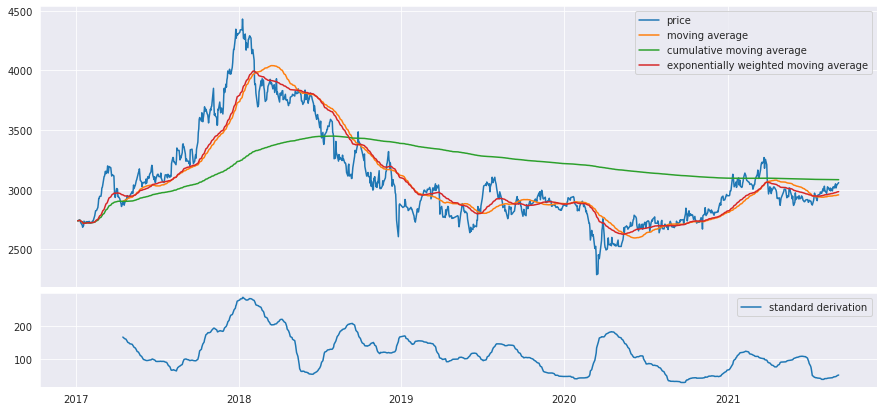

In [9]:
span = 70
indicators(df_train, 'Close', span=span)

#### Price minus moving average analysis

ADF Statistics -3.783539042096147
p-value 0.0030802942909856205
Critical values
	1%: -3.4364762217105844
	5%: -2.8642449457774135
	10%: -2.5682102104987337


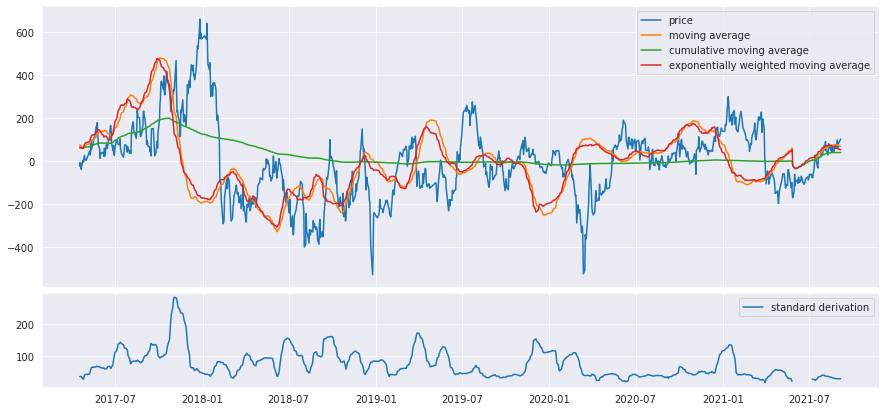

In [10]:
df_train[f'Close_minus_SMA{span}'] = df_train.Close - df_train[f'Close_SMA{span}']
df_train_filtered = df_train[[f'Close_minus_SMA{span}', 'SecuritiesCode', 'Date']].copy()
df_train_filtered.dropna(subset=[f'Close_minus_SMA{span}'], inplace=True)

indicators(df_train_filtered, f'Close_minus_SMA{span}')


Moving average and std are approximately horizontal. p-value is above .05 and ADF statistic is close to critical values. Therefore the timeseries is stationary

#### Exponential decay

ADF Statistics -4.340081175574937
p-value 0.0003783330174776982
Critical values
	1%: -3.4361245824564977
	5%: -2.8640898339013243
	10%: -2.56812759902191


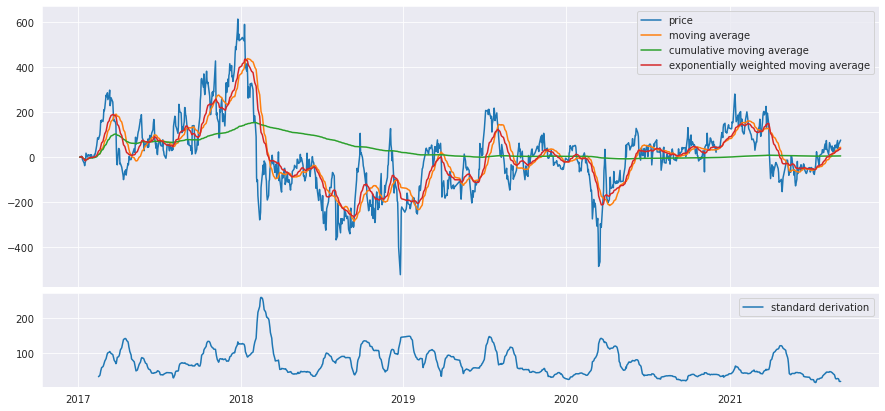

In [11]:
df_train[f'Close_minus_EWMA{span}'] = df_train.Close - df_train[f'Close_EWMA{span}']

indicators(df_train, f'Close_minus_EWMA{span}')

#### Previous value substraction

ADF Statistics -16.038979085799586
p-value 5.942801569992926e-29
Critical values
	1%: -3.4361245824564977
	5%: -2.8640898339013243
	10%: -2.56812759902191


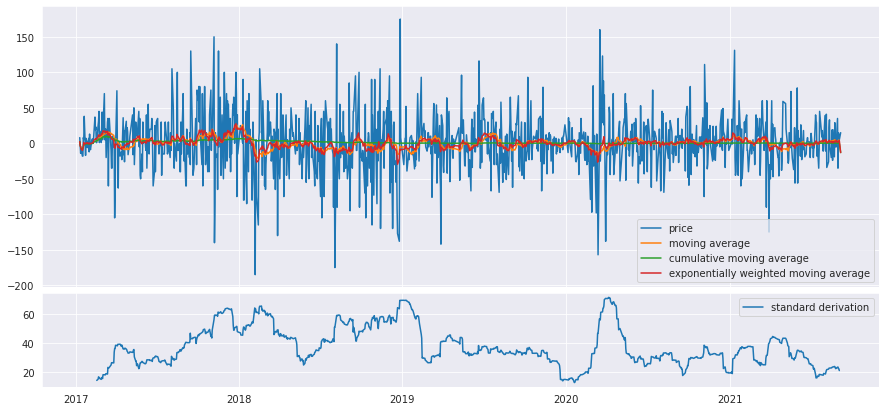

In [12]:
df_train[f'Close_diff1'] = df_train.groupby('SecuritiesCode').Close.diff()
df_train_filtered = df_train[[f'Close_diff1', 'SecuritiesCode', 'Date']].copy()
df_train_filtered.dropna(subset=[f'Close_diff1'], inplace=True)

indicators(df_train_filtered, f'Close_diff1')

### PACF & ACF

## ARIMA Model

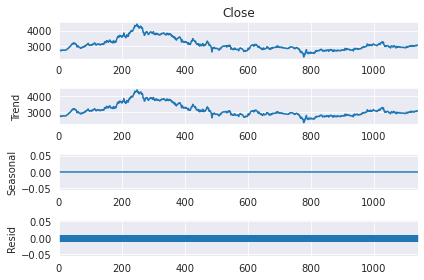

In [13]:
decomposition = seasonal_decompose(dft_sx.Close, period=1, model='additive')
p = decomposition.plot()

So, this is not decomposable

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=11619.829, Time=0.33 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=11616.319, Time=0.04 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=11618.271, Time=0.10 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=11618.265, Time=0.21 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=11614.377, Time=0.02 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.717 seconds
1140 1199 (59,)


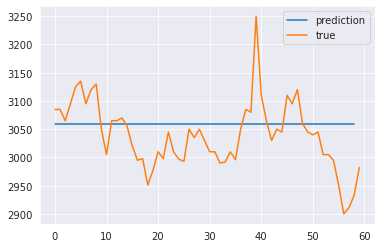

In [14]:
from pmdarima import auto_arima

stepwise_fit: ARIMA = auto_arima(
    dft_sx.Close,
    start_p=1, start_q=1,
    max_p=50, max_q=50, seasonal=False,
    d=None, D=1,
    trace=True, error_action='ignore',
    supress_warnings=False,
    stepwise=True
)
stepwise_fit.summary()

start = len(dft_sx)
end = len(dft_sx) + len(dfv_sx) - 1
predictions = stepwise_fit.predict(end - start)
print(start, end, predictions.shape)
plt.plot(predictions, label='prediction')
plt.plot(dfv_sx.index, dfv_sx.Close, label='true')
plt.legend()

/home/cyprien/anaconda3/envs/pytorch/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/home/cyprien/anaconda3/envs/pytorch/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/home/cyprien/anaconda3/envs/pytorch/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


CPU times: user 8min 3s, sys: 1.12 s, total: 8min 4s
Wall time: 1min 20s


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  Close   No. Observations:                 1140
Model:               ARIMA(40, 1, 20)   Log Likelihood               -5776.409
Date:                Sun, 12 Jun 2022   AIC                          11674.819
Time:                        11:47:36   BIC                          11982.131
Sample:                             0   HQIC                         11790.879
                               - 1140                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.2419      2.313     -0.105      0.917      -4.775       4.291
ar.L2         -0.0527      1.648     -0.032      0.974      -3.283       3.178
ar.L3         -0.0500      1.391     -0.036      0.971      -2.777       2.677
ar.L4         -0.1805      1.510     -0.120      0.905      -3.140       2.779
ar.L5         -0.2027      1.339     -0.151      0.880      -2.828       2.422
ar.L6         -0.0037      1.201     -0.003      0.998      -2.357       2.350
ar.L7          0.2468      1.219      0.202      0.840      -2.143       2.636
ar.L8          0.0424      0.612      0.069      0.945      -1.158       1.243
ar.L9         -0.0529      0.665     -0.080      0.937      -1.357       1.251
ar.L10         0.0525      0.737      0.071      0.943      -1.393       1.498
ar.L11         0.0005      0.797      0.001      1.000      -1.562       1.563
ar.L12        -0.2298      0.767     -0.300      0.764      -1.733       1.273
ar.L13        -0.4660      0.312     -1.492      0.136      -1.078       0.146
ar.L14        -0.1108      1.086     -0.102      0.919      -2.240       2.018
ar.L15         0.0151      0.767      0.020      0.984      -1.488       1.518
ar.L16        -0.1683      0.635     -0.265      0.791      -1.413       1.076
ar.L17        -0.1861      0.759     -0.245      0.806      -1.675       1.302
ar.L18        -0.3449      0.710     -0.486      0.627      -1.737       1.047
ar.L19         0.0039      0.966      0.004      0.997      -1.889       1.897
ar.L20         0.1985      0.995      0.200      0.842      -1.751       2.148
ar.L21         0.0261      0.205      0.127      0.899      -0.376       0.428
ar.L22         0.0211      0.240      0.088      0.930      -0.450       0.492
ar.L23         0.0071      0.121      0.059      0.953      -0.230       0.244
ar.L24        -0.0808      0.111     -0.730      0.465      -0.298       0.136
ar.L25        -0.0059      0.211     -0.028      0.978      -0.420       0.408
ar.L26        -0.0294      0.192     -0.154      0.878      -0.405       0.346
ar.L27        -0.0161      0.195     -0.082      0.934      -0.399       0.367
ar.L28        -0.0718      0.169     -0.426      0.670      -0.402       0.259
ar.L29        -0.0006      0.191     -0.003      0.997      -0.374       0.373
ar.L30        -0.0781      0.179     -0.436      0.663      -0.429       0.273
ar.L31        -0.0429      0.225     -0.191      0.849      -0.484       0.398
ar.L32         0.0085      0.218      0.039      0.969      -0.419       0.436
ar.L33         0.0149      0.217      0.069      0.945      -0.410       0.440
ar.L34        -0.0021      0.198     -0.011      0.991      -0.390       0.386
ar.L35        -0.0293      0.195     -0.150      0.881      -0.412       0.354
ar.L36        -0.0717      0.229     -0.312      0.755      -0.521       0.378
ar.L37        -0.0086      0.091     -0.094      0.925      -0.188       0.171
ar.L38        -0.0279      0.083     -0.336      0.737      -0.190       0.135
ar

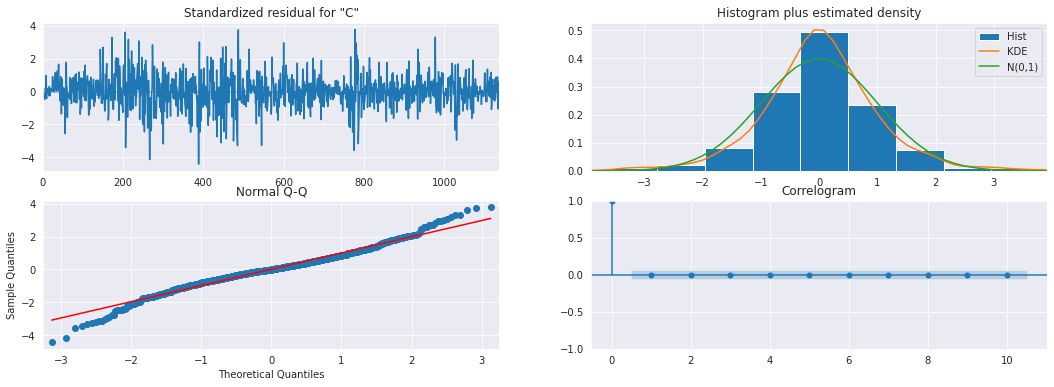

In [15]:
%%time

model = ARIMA(dft_sx.Close, order=(40, 1, 20))  # 50 1 3 did ok
results = model.fit()

results.plot_diagnostics(figsize=(18, 6))
results.summary()

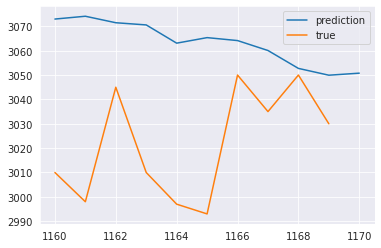

In [16]:
start = len(dft_sx) + 20
end = start + len(dfv_sx) - 1
end = start + 10
predictions = results.predict(start, end)

plt.plot(predictions, label='prediction')
plt.plot((dfv_sx.index + len(dft_sx))[start - len(dft_sx):start - len(dft_sx) + (end - start)], dfv_sx.Close[start - len(dft_sx):start - len(dft_sx) + (end - start)], label='true')
plt.legend()

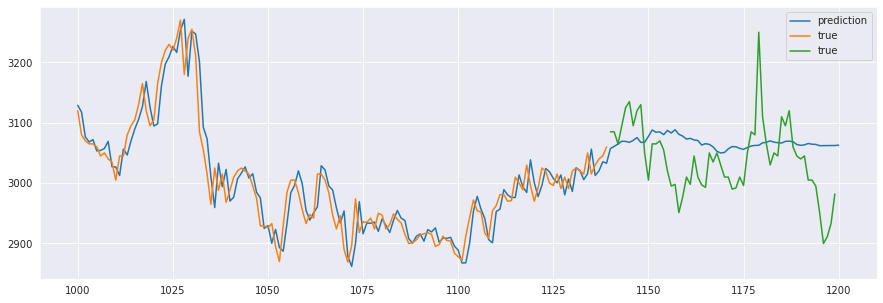

In [17]:
start = 1000
end = 1200
predictions = results.predict(start, end)
plt.figure(figsize=(15, 5))
plt.plot(predictions, label='prediction')
plt.plot(dft_sx.index[start: end], dft_sx.Close[start: end], label='true')
plt.plot(dfv_sx.index[0: end - len(dft_sx)] + len(dft_sx), dfv_sx.Close[0: end-len(dft_sx)], label='true')
plt.legend()

In [18]:
dfv_sx_shifted = dfv_sx.copy()
dfv_sx_shifted.index += len(dft_sx)

### Forecasting

  0%|          | 0/60 [00:00<?, ?it/s]

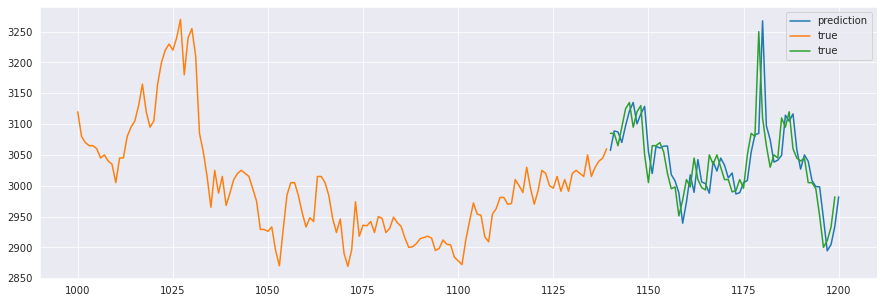

In [19]:
forecasts = []
res = results
forecasts.append(res.forecast())

for t in tqdm(range(len(dfv_sx_shifted))):
    # Update the results by appending the next observation
    new_value = dfv_sx_shifted.Close.iloc[t:t + 1]
    res = res.append(new_value, refit=False)

    # Produce a forecast for t+1 based on data through t
    forecasts.append(res.forecast())

forecasts = pd.Series([e.item() for e in forecasts],  index=[e.index[0] for e in forecasts])

start = 1000
end = 1200
plt.figure(figsize=(15, 5))
plt.plot(forecasts.loc[:end], label='prediction')
plt.plot(dft_sx.index[start: end], dft_sx.Close[start: end], label='true')
plt.plot(dfv_sx.index[0: end - len(dft_sx)] + len(dft_sx), dfv_sx.Close[0: end-len(dft_sx)], label='true')
plt.legend()

### Train of each SecuritiesCode

In [20]:
number_of_sc = 20

scs = df_train.SecuritiesCode.unique()[:number_of_sc]

df_train_subset = df_train.loc[df_train.SecuritiesCode.isin(scs)].copy()
df_val_subset_shifted = df_val.loc[df_val.SecuritiesCode.isin(scs)].copy()
df_val_subset_shifted.loc[:, 'idx'] = df_val_subset_shifted.index
df_train_subset.loc[:, 'idx'] = df_train_subset.index

df_val_subset_shifted['idx'] = df_val_subset_shifted.groupby('SecuritiesCode').apply(lambda x: pd.Series(x.idx - x.idx.min()) + len(df_train[df_train.SecuritiesCode == x.name])).reset_index(drop=True)
df_train_subset['idx'] = df_train_subset.groupby('SecuritiesCode').apply(lambda x: pd.Series(x.idx - x.idx.min())).reset_index(drop=True)


KeyboardInterrupt: 

In [ ]:
%%time

ARIMAs = df_train_subset.groupby('SecuritiesCode').Close.progress_apply(lambda x: ARIMA(x.to_numpy(), order=(40, 1, 20)).fit()).to_frame('model')

  0%|          | 0/200 [00:00<?, ?it/s]

/home/cyprien/anaconda3/envs/pytorch/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/home/cyprien/anaconda3/envs/pytorch/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/home/cyprien/anaconda3/envs/pytorch/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/cyprien/anaconda3/envs/pytorch/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood op

Forecasting 1301:   0%|          | 0/59 [00:00<?, ?it/s]

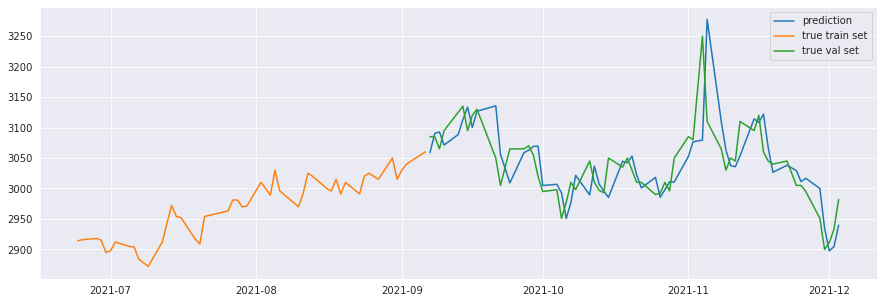

Forecasting 1332:   0%|          | 0/59 [00:00<?, ?it/s]

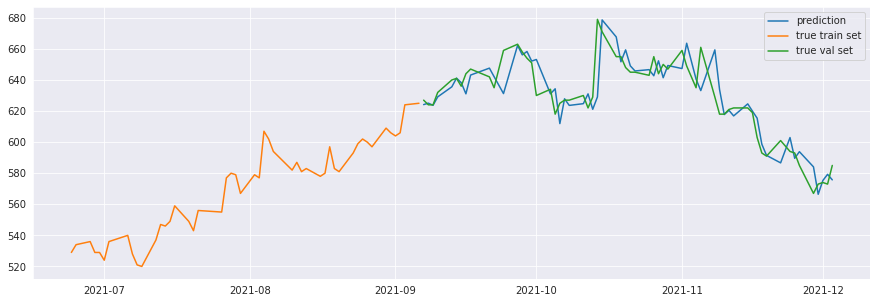

Forecasting 1333:   0%|          | 0/59 [00:00<?, ?it/s]

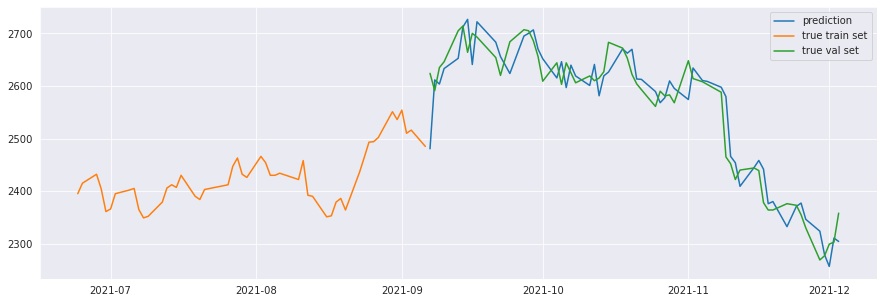

Forecasting 1375:   0%|          | 0/14 [00:00<?, ?it/s]

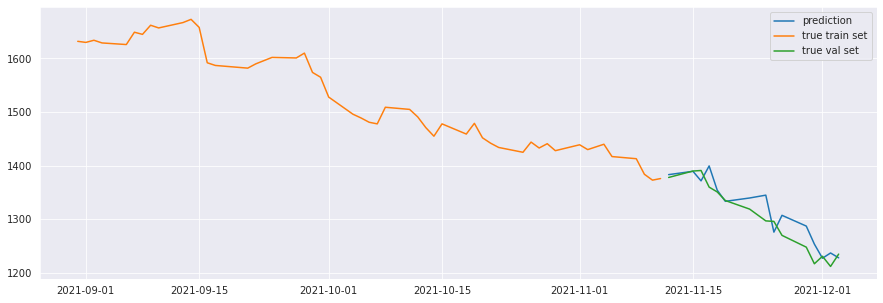

Forecasting 1376:   0%|          | 0/59 [00:00<?, ?it/s]

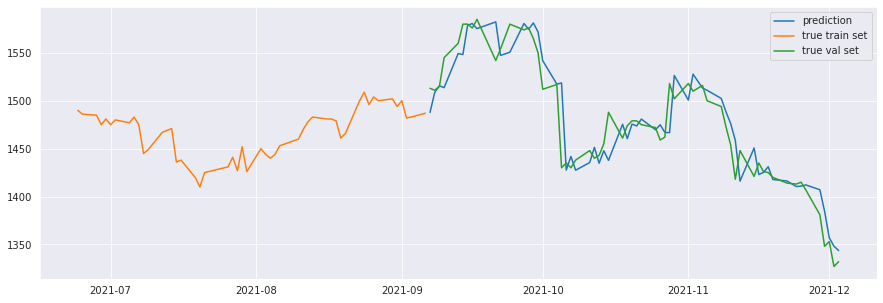

In [52]:
k = 2

def forecast_on_sc(df_: pd.DataFrame, model_):
    df_.set_index('idx', inplace=True)
    forecasts_ = []
    forecasts_.append(model_.forecast(k))

    for t in tqdm(range(len(df_)-1), desc=f'Forecasting {df_.name}'):
        new_value = df_.Close.iloc[t:t + 1]
        model_ = model_.append(new_value, refit=False)

        forecasts_.append(model_.forecast(k))

    forecasts_1 = pd.Series([e[0] for e in forecasts_],  index=df_.index)
    df_['Close_pred'] = forecasts_1
    df_['Target_pred'] = pd.Series([((e[1] - e[0]) / e[0]) for e in forecasts_],  index=df_.index)

    start = df_.index.min() - 50
    end = df_.index.max()
    plt.figure(figsize=(15, 5))
    plt.plot(df_.loc[:end, 'Date'], forecasts_1.loc[:end], label='prediction')

    dft_tc = df_train_subset[df_train_subset.SecuritiesCode == df_.name].copy()
    dft_tc.set_index('idx', inplace=True)

    plt.plot(dft_tc.loc[start:, 'Date'], dft_tc.loc[start:, 'Close'], label='true train set')
    plt.plot(df_.loc[:end, 'Date'], df_.loc[:end, 'Close'], label='true val set')
    plt.legend()
    plt.show()
    return df_.reset_index(drop=True)

df_val_subset_shifted = df_val_subset_shifted.groupby('SecuritiesCode').apply(lambda x: forecast_on_sc(x, ARIMAs.loc[x.name][0]))

In [53]:
df_val_subset_shifted


RowId       Date SecuritiesCode    Open    High  \
SecuritiesCode                                                               
1301           0   20210907_1301 2021-09-07           1301  3065.0  3090.0   
               1   20210908_1301 2021-09-08           1301  3090.0  3090.0   
               2   20210909_1301 2021-09-09           1301  3085.0  3085.0   
               3   20210910_1301 2021-09-10           1301  3035.0  3095.0   
               4   20210913_1301 2021-09-13           1301  3090.0  3125.0   
...                          ...        ...            ...     ...     ...   
1376           55  20211129_1376 2021-11-29           1376  1403.0  1403.0   
               56  20211130_1376 2021-11-30           1376  1380.0  1387.0   
               57  20211201_1376 2021-12-01           1376  1326.0  1374.0   
               58  20211202_1376 2021-12-02           1376  1353.0  1373.0   
               59  20211203_1376 2021-12-03           1376  1370.0  1370.0   

                      Low   Close  Volume  AdjustmentFactor  ExpectedDividend  \
SecuritiesCode                                                                  
1301           0   3060.0  3085.0   18300               1.0               0.0   
               1   3070.0  3085.0   12500               1.0               0.0   
               2   3045.0  3065.0    9200               1.0               0.0   
               3   3035.0  3095.0   18900               1.0               0.0   
               4   3085.0  3125.0   18000               1.0               0.0   
...                   ...     ...     ...               ...               ...   
1376           55  1357.0  1381.0    9000               1.0               0.0   
               56  1336.0  1348.0   10300               1.0               0.0   
               57  1326.0  1353.0    4200               1.0               0.0   
               58  1327.0  1327.0    7800               1.0               0.0   
               59  1321.0  1332.0    5000               1.0               0.0   

                   ... predict_target  Open_scaled  High_scaled  Low_scaled  \
SecuritiesCode     ...                                                        
1301           0   ...       0.008170    -0.050798    -0.045259    0.001353   
               1   ...       0.000000     0.012923    -0.045259    0.027093   
               2   ...      -0.006483     0.000179    -0.057853   -0.037259   
               3   ...       0.009788    -0.127264    -0.032664   -0.063000   
               4   ...       0.009693     0.012923     0.042903    0.065705   
...                ...            ...          ...          ...         ...   
1376           55  ...      -0.018479    -0.578805    -0.666327   -0.793772   
               56  ...      -0.023896    -0.748137    -0.784528   -0.948294   
               57  ...       0.003709    -1.145700    -0.880566   -1.021876   
               58  ...      -0.019217    -0.946919    -0.887954   -1.014517   
               59  ...       0.003768    -0.821760    -0.910116   -1.058666   

                   Close_scaled  Volume_scaled  is_testing  is_val  \
SecuritiesCode                                                       
1301           0       0.000904      -0.458675       False    True   
               1       0.000904      -0.734105       False    True   
               2      -0.050012      -0.890815       False    True   
               3       0.026363      -0.430182       False    True   
               4       0.102738      -0.472921       False    True   
...                         ...            ...         ...     ...   
1376           55     -0.714660       0.479456       False    True   
               56     -0.957703       0.749896       False    True   
               57     -0.920878      -0.519092       False    True   
               58     -1.112367       0.229819       False    True   
               59     -1.075543      -0.352667       False    True   

                   

In [59]:
tp = ((df_val_subset_shifted.Target > 0) == (df_val_subset_shifted.Target_pred > 0)).sum()
fp = ((df_val_subset_shifted.Target <= 0) == (df_val_subset_shifted.Target_pred > 0)).sum()
tn = ((df_val_subset_shifted.Target <= 0) == (df_val_subset_shifted.Target_pred <= 0)).sum()
fn = ((df_val_subset_shifted.Target > 0) == (df_val_subset_shifted.Target_pred <= 0)).sum()

tp, tn, fp, fn

(130, 130, 125, 125)

In [72]:
df_val_subset_shifted

,RowId,Date,SecuritiesCode,Open,High,Low,Close,Volume,AdjustmentFactor,ExpectedDividend,...,predict_target,Open_scaled,High_scaled,Low_scaled,Close_scaled,Volume_scaled,is_testing,is_val,Close_pred,Target_pred
0,20210907_1301,2021-09-07,1301,3065.0,3090.0,3060.0,3085.0,18300,1.0,0.0,...,0.008170,-0.050798,-0.045259,0.001353,0.000904,-0.458675,False,True,3058.948601,0.001777
1,20210908_1301,2021-09-08,1301,3090.0,3090.0,3070.0,3085.0,12500,1.0,0.0,...,0.000000,0.012923,-0.045259,0.027093,0.000904,-0.734105,False,True,3090.421671,0.002526
2,20210909_1301,2021-09-09,1301,3085.0,3085.0,3045.0,3065.0,9200,1.0,0.0,...,-0.006483,0.000179,-0.057853,-0.037259,-0.050012,-0.890815,False,True,3092.810302,0.002022
3,20210910_1301,2021-09-10,1301,3035.0,3095.0,3035.0,3095.0,18900,1.0,0.0,...,0.009788,-0.127264,-0.032664,-0.063000,0.026363,-0.430182,False,True,3071.268723,-0.002087
4,20210913_1301,2021-09-13,1301,3090.0,3125.0,3085.0,3125.0,18000,1.0,0.0,...,0.009693,0.012923,0.042903,0.065705,0.102738,-0.472921,False,True,3088.578448,-0.003867
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
250,20211129_1376,2021-11-29,1376,1403.0,1403.0,1357.0,1381.0,9000,1.0,0.0,...,-0.018479,-0.578805,-0.666327,-0.793772,-0.714660,0.479456,False,True,1407.087746,0.001865
251,20211130_1376,2021-11-30,1376,1380.0,1387.0,1336.0,1348.0,10300,1.0,0.0,...,-0.023896,-0.748137,-0.784528,-0.948294,-0.957703,0.749896,False,True,1384.688277,0.005434
252,20211201_1376,2021-12-01,1376,1326.0,1374.0,1326.0,1353.0,4200,1.0,0.0,...,0.003709,-1.145700,-0.880566,-1.021876,-0.920878,-0.519092,False,True,1357.021730,-0.003701
253,20211202_1376,2021-12-02,1376,1353.0,1373.0,1327.0,1327.0,7800,1.0,0.0,...,-0.019217,-0.946919,-0.887954,-1.014517,-1.112367,0.229819,False,True,1348.141207,0.011663


In [73]:

df_val_subset_shifted.sort_values(by=['Target_pred'], ascending=False)

tp = ((df_val_subset_shifted.iloc[-50:].Target > 0) == (df_val_subset_shifted.iloc[-50:].Target_pred > 0)).sum()
fp = ((df_val_subset_shifted.iloc[-50:].Target <= 0) == (df_val_subset_shifted.iloc[-50:].Target_pred > 0)).sum()
tn = ((df_val_subset_shifted.iloc[-50:].Target <= 0) == (df_val_subset_shifted.iloc[-50:].Target_pred <= 0)).sum()
fn = ((df_val_subset_shifted.iloc[-50:].Target > 0) == (df_val_subset_shifted.iloc[-50:].Target_pred <= 0)).sum()

tp, tn, fp, fn

(30, 30, 20, 20)

In [66]:
df_val_subset_shifted.reset_index(drop=True, inplace=True)

In [68]:
df_val_subset_shifted.sort_values(by=['SecuritiesCode', 'Date']).loc[:, ['SecuritiesCode', 'Target', 'Target_pred']]

,SecuritiesCode,Target,Target_pred
0,1301,-0.006483,0.001777
1,1301,0.009788,0.002526
2,1301,0.009693,0.002022
3,1301,0.003200,-0.002087
4,1301,-0.012759,-0.003867
...,...,...,...
250,1376,0.003709,0.001865
251,1376,-0.019217,0.005434
252,1376,0.003768,-0.003701
253,1376,0.014264,0.011663
